# Model growth and N residuals
* Goal: Model growth and N uptake by DAP in order to detrend data.  Save residuals for use in other analyses.
* Conclusions -log linear model seems to be te best fit to detrend Biomass and N uptake data, residuals saved in Master table in notebook but not saved to file.  Enzyme data is positively correlated with N uptake residuals, however, effect is not significant when plant functional group is included in the model


## Set Variables

In [77]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/figures/'
fullData = '/home/bryan/RhizCG/data/MiSeq_amplicon/Master20160506.txt'
SampleA = '/home/bryan/RhizCG/data/MiSeq_amplicon/20130724Sampling.csv'

# Init

In [35]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [36]:
%%R
library(Hmisc)
library(ggplot2)
library(dplyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(cowplot)



### Read  master table 

In [78]:
%%R -i fullData -i workDir
setwd(workDir)
Master = read.delim(fullData, header = TRUE)
Master$Rep = as.factor(Master$Rep)
colnames(Master)


# Master$Resid_logB = NULL
# Master$Resid_logN = NULL
# Master$Resid_logCN = NULL
# Master$Resid_logSLA = NULL
# Master$Resid_LeafN = NULL
      

 [1] "Unique"             "PlotID"             "Plant"             
 [4] "Plot"               "Treatment"          "Rep"               
 [7] "DAP"                "Sampling"           "PlantSample"       
[10] "Type"               "Grass_Broad"        "Status"            
[13] "Subfamily"          "Symbol_class"       "Plant_num"         
[16] "Leaf_AreaBiomass_g" "Biomass_T"          "Biomass_P"         
[19] "Leaf_Area_cm2"      "SLA"                "Leaf_N"            
[22] "Leaf_C"             "LeafC_N"            "LNa"               
[25] "Plant_N"            "Plant_C"            "Plant_CN"          
[28] "d15N"               "tN_p"               "BX_act"            
[31] "CB_act"             "LAP_act"            "NAG_act"           
[34] "soil_dw"            "BX_activity_g"      "CB_activity_g"     
[37] "LAP_activity_g"     "NAG_activity_g"     "BX_barefactor"     
[40] "CB_barefactor"      "LAP_barefactor"     "NAG_barefactor"    
[43] "BX_dif"             "CB_dif"             "

In [79]:
%%R
# remove samples for which there is no microbial community or enzyme data
Master = filter(Master, !is.na(BX_dif))
Annuals = filter(Master, Type != "Maize" & Plant != "BARE" | Plant == "B73")


# Join 7/26/13 data to improve estimation of biomass and N accumulation of annuals

In [80]:
%%R -i SampleA
SA = read.csv(SampleA, header = TRUE)
colnames(SA)
SA = filter(SA, Plant != "Ky21")
levels(SA$Plant)

# Biomass_full = rbind(Master_sub, SA)


 [1] "75-062" "ECHCG"  "ERATE"  "H99"    "HELAN"  "Hp301"  "Ky21"   "Mo18"  
 [9] "Oh7B"   "Tx303" 


In [81]:
%%R
colnames(SA)

 [1] "Plot"      "Plant"     "Treatment" "PlotID"    "DAP"       "Unique"   
 [7] "Plant_num" "Biomass_T" "Biomass_P" "Plant_C"   "Plant_N"   "tN_p"     
[13] "Plant_CN" 


In [106]:
%%R
Biomass_M$Plant %>% levels

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "BARE"   "ECHCG"  "ELCOR" 
 [9] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[17] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303"  "Ky21"  


In [104]:
%%R
dim(SA)

[1] 70 13


In [107]:
%%R
#Subset SA for respective growth curvers
    SA_annuals = filter(SA, Plant %in% c("ECHCG", "HELAN", "ERATE"))
    SA_maize = filter(SA, Plant %in% c("75-062", "H99", "Hp301",  "Mo18", "Oh7B", "Tx303"))

# #Subsest Annuals and Maize datasets
# #trim master sheet columns to match Sample A
    Annuals = filter(Master, Type != "Maize" & Plant != "SETIT" & Plant != "PANMI" & Plant != "BARE" | Plant == "B73")
    Annuals_sub = Annuals[,c("Plot", "Plant", "Treatment", "PlotID", "DAP","Unique", 
                       "Plant_num", "Biomass_T", "Biomass_P", "Plant_C", "Plant_N", 
                       "tN_p", "Plant_CN")]
    
    Maize = filter(Master, Type == "Maize")
    Maize_sub = Maize[,c("Plot", "Plant", "Treatment", "PlotID", "DAP","Unique", 
                       "Plant_num", "Biomass_T", "Biomass_P", "Plant_C", "Plant_N", 
                       "tN_p", "Plant_CN")]
    
    Master_sub = Master[,c("Plot", "Plant", "Treatment", "PlotID", "DAP","Unique", 
                       "Plant_num", "Biomass_T", "Biomass_P", "Plant_C", "Plant_N", 
                       "tN_p", "Plant_CN")]
    
    

# #Note that Annuals includes B73 as reference maize
   
    Biomass_A = rbind(Annuals_sub, SA_annuals)
     Biomass_M = rbind(Maize_sub, SA_maize)
        Biomass_F = rbind(Master_sub, SA)


# #clear variables
    SA_annuals = NULL
    SA_maize = NULL
    Annuals_sub = NULL
    Maize_sub = NULL
    
# #tables Annuals and Maize saved for downstream analysis

In [108]:
%%R
dim(Biomass_M) %>% print
dim(Biomass_A) %>% print

[1] 134  13
[1] 120  13


## Model DAP vs biomass


Call:
lm(formula = log(Biomass_P) ~ I(DAP) + I(DAP^2), data = Biomass_A)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.17087 -0.31204  0.01027  0.44693  1.50544 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.4263804  0.7655162  -4.476 1.78e-05 ***
I(DAP)       0.1702016  0.0270398   6.294 5.56e-09 ***
I(DAP^2)    -0.0008031  0.0002204  -3.645 0.000401 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6544 on 117 degrees of freedom
Multiple R-squared:  0.8227,	Adjusted R-squared:  0.8197 
F-statistic: 271.4 on 2 and 117 DF,  p-value: < 2.2e-16

NULL


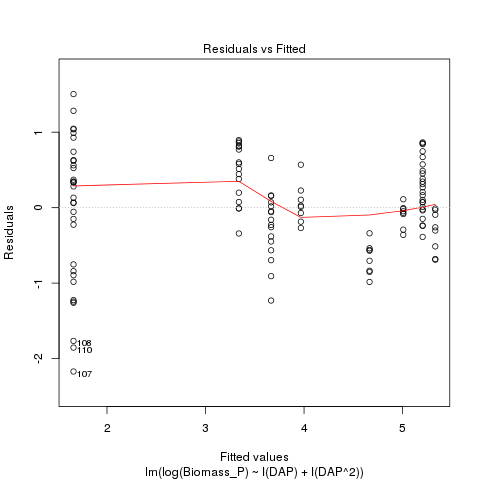

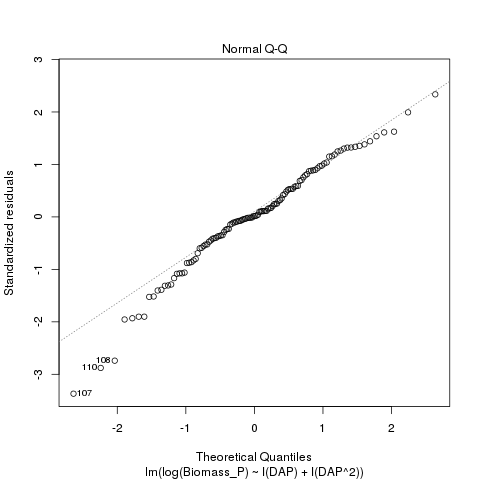

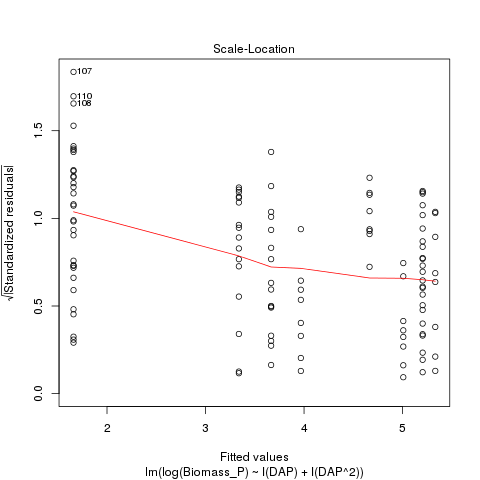

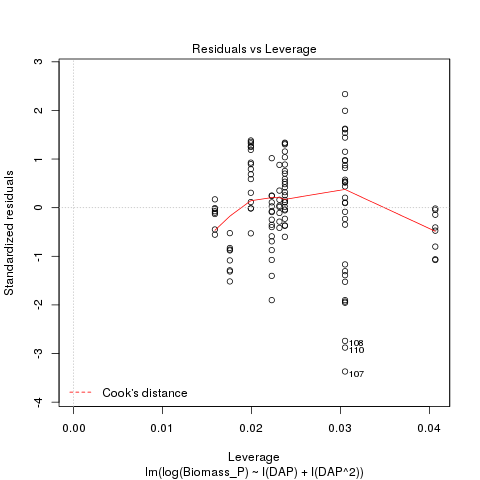

In [109]:
%%R
# model annuals
fit1_A <- lm(log(Biomass_P)~ I(DAP) + I(DAP^2), data = Biomass_A)
summary(fit1_A) %>% print
plot(fit1_A) %>% print



In [110]:
%%R
# predict using annualsand save to table
A_Pred_B = predict(fit1_A, Master, se.fit = TRUE)
A_resid_B = log(Master$Biomass_P) - A_Pred_B$fit
Master$A_Resid_logB = log(Master$Biomass_P) - A_Pred_B$fit





Call:
lm(formula = log(Biomass_P) ~ I(DAP) + I(DAP^2), data = Biomass_M)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82317 -0.20030  0.01817  0.18951  0.93581 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.3598706  0.4086323 -10.669  < 2e-16 ***
I(DAP)       0.1959300  0.0155570  12.594  < 2e-16 ***
I(DAP^2)    -0.0010429  0.0001308  -7.972 6.72e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3337 on 131 degrees of freedom
Multiple R-squared:  0.956,	Adjusted R-squared:  0.9553 
F-statistic:  1423 on 2 and 131 DF,  p-value: < 2.2e-16

NULL


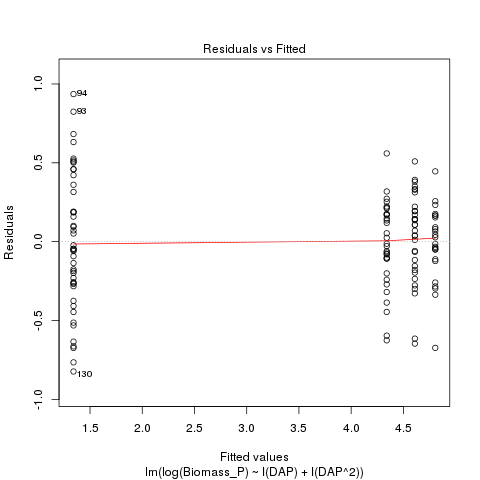

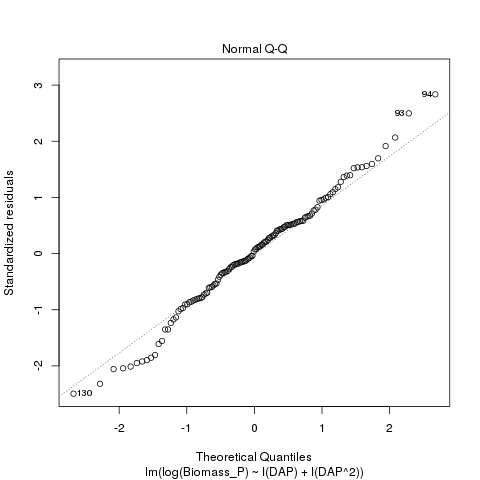

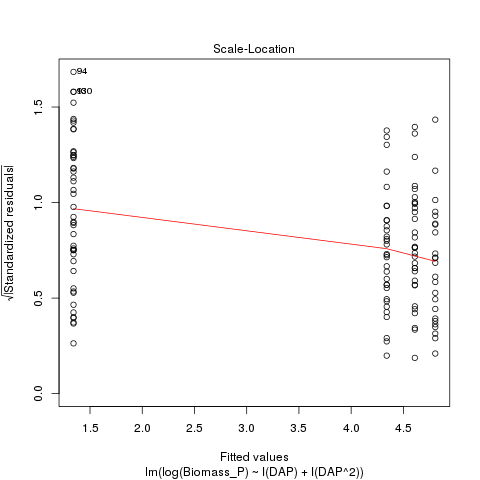

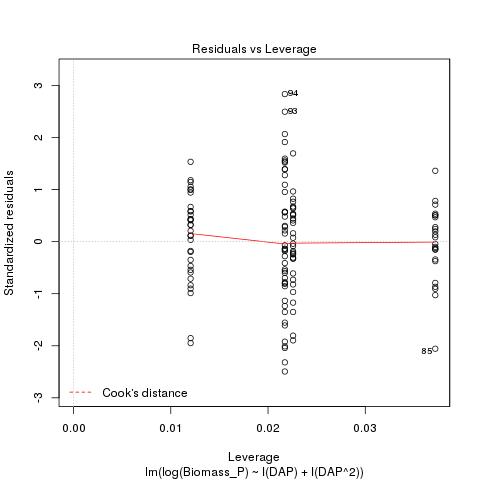

In [111]:
%%R
# model maize only
fit1_M <- lm(log(Biomass_P)~ I(DAP) + I(DAP^2), data = Biomass_M)
summary(fit1_M) %>% print
plot(fit1_M) %>% print

# predict using maize
M_Pred_B = predict(fit1_M, Master, se.fit = TRUE)
Master$M_Resid_logB = log(Master$Biomass_P) - M_Pred_B$fit

In [112]:
%%R
# get correct coefficients
coef(fit1_A) %>% print
coef(fit1_M) %>% print

 (Intercept)       I(DAP)     I(DAP^2) 
-3.426380445  0.170201623 -0.000803116 
 (Intercept)       I(DAP)     I(DAP^2) 
-4.359870581  0.195929984 -0.001042934 


## N uptake over time

In [113]:
%%R
#linear model for annuals

fit2_A <- lm(log(tN_p)~ I(DAP) + I(DAP^2), data = Biomass_A)

Pred_N = predict(fit2_A, Master, se.fit = TRUE)
Master$A_Resid_logN = log(Master$tN_p) - Pred_N$fit
summary(fit2_A)


Call:
lm(formula = log(tN_p) ~ I(DAP) + I(DAP^2), data = Biomass_A)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.18716 -0.37418  0.03646  0.40906  1.44859 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.6156327  0.7744568  -7.251 4.83e-11 ***
I(DAP)       0.1416572  0.0273556   5.178 9.42e-07 ***
I(DAP^2)    -0.0007443  0.0002229  -3.339  0.00113 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6621 on 117 degrees of freedom
Multiple R-squared:  0.696,	Adjusted R-squared:  0.6908 
F-statistic: 133.9 on 2 and 117 DF,  p-value: < 2.2e-16



In [114]:
%%R
# Maize
#linear model

    fit2_M <- lm(log(tN_p)~ I(DAP) + I(DAP^2), data = Biomass_M)
    summary(fit2_M) %>% print

# save residuals
Pred_N = predict(fit2_M, Master, se.fit = TRUE)
Master$M_Resid_logN = log(Master$tN_p) - Pred_N$fit


Call:
lm(formula = log(tN_p) ~ I(DAP) + I(DAP^2), data = Biomass_M)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.84680 -0.21524 -0.00277  0.25674  0.88264 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.7645054  0.4455499 -12.938  < 2e-16 ***
I(DAP)       0.1268762  0.0169625   7.480 9.57e-12 ***
I(DAP^2)    -0.0006257  0.0001426  -4.387 2.34e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3638 on 131 degrees of freedom
Multiple R-squared:  0.906,	Adjusted R-squared:  0.9045 
F-statistic: 631.2 on 2 and 131 DF,  p-value: < 2.2e-16



## model NUE

In [115]:
%%R
#linear model of plant C:N

fit3_A <- lm(log(Plant_CN) ~ DAP, data = Biomass_A)
summary(fit3_A) %>% print

#log model satisfies assumptions of evenly distributed residuals, 
#whereas polynomial does not improve

## save residuals
Pred_CN = predict(fit3_A, Master, se.fit = TRUE)

Master$A_Resid_logCN = log(Master$Plant_CN) - Pred_CN$fit


Call:
lm(formula = log(Plant_CN) ~ DAP, data = Biomass_A)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62393 -0.15850  0.00348  0.15551  0.71306 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.398205   0.074649   18.73   <2e-16 ***
DAP         0.023313   0.001167   19.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2431 on 118 degrees of freedom
Multiple R-squared:  0.7717,	Adjusted R-squared:  0.7698 
F-statistic:   399 on 1 and 118 DF,  p-value: < 2.2e-16



In [116]:
%%R
#linear model of maize NUE

fit3_M <- lm(log(Plant_CN) ~ DAP, data = Biomass_M)
summary(fit3_M) %>% print

#log model satisfies assumptions of evenly distributed residuals, 
#whereas polynomial does not improve

## save residuals
Pred_CN = predict(fit3_M, Master, se.fit = TRUE)

Master$M_Resid_logCN = log(Master$Plant_CN) - Pred_CN$fit



Call:
lm(formula = log(Plant_CN) ~ DAP, data = Biomass_M)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.49050 -0.09847 -0.02616  0.08784  0.54135 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.7798839  0.0496003   35.88   <2e-16 ***
DAP         0.0206555  0.0007345   28.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1786 on 132 degrees of freedom
Multiple R-squared:  0.857,	Adjusted R-squared:  0.8559 
F-statistic: 790.8 on 1 and 132 DF,  p-value: < 2.2e-16



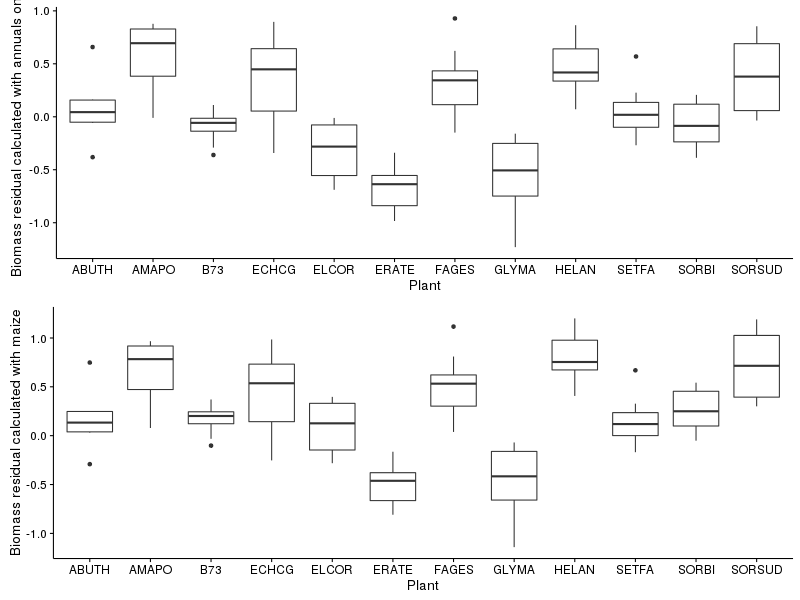

In [117]:
%%R -h 600 -w 800
#compare residuals from original and annuals only growth curve
Atemp = filter(Master, Type != "Maize" & Plant != "SETIT" & Plant != "PANMI" & Plant != "BARE" | Plant == "B73")
p = ggplot(Atemp, aes(x = Plant, y = A_Resid_logB))
p = p + geom_boxplot(stat = "boxplot")
p = p + ylab("Biomass residual calculated with annuals only")
#p = p + theme(axis.text.x = element_text(size = rel(1.5), angle = 60))

p1 = ggplot(Atemp, aes(x = Plant, y = Resid_logB))
p1 = p1 + geom_boxplot(stat = "boxplot")
p1 = p1 + ylab("Biomass residual calculated with maize")
grid.arrange(p, p1, ncol = 1)

* Biomass model does shift when just annuals are included, line is signficantly different for later season plants

* N uptake residuals do shift with line, later season plants are magnified

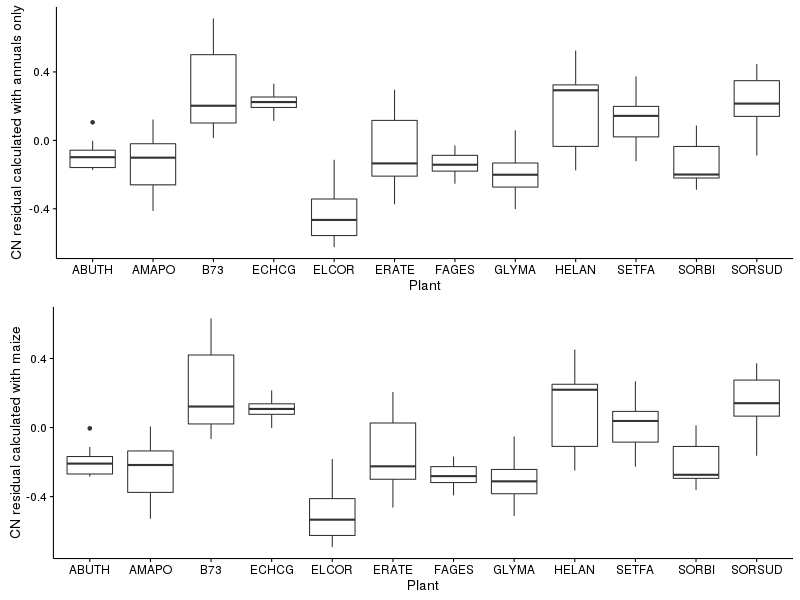

In [118]:
%%R -h 600 -w 800
#compare residuals from original and annuals only growth curve
Atemp = filter(Master, Type != "Maize" & Plant != "SETIT" & Plant != "PANMI" & Plant != "BARE" | Plant == "B73")
p = ggplot(Atemp, aes(x = Plant, y = A_Resid_logCN))
p = p + geom_boxplot(stat = "boxplot")
p = p + ylab("CN residual calculated with annuals only")
#p = p + theme(axis.text.x = element_text(size = rel(1.5), angle = 60))

p1 = ggplot(Atemp, aes(x = Plant, y = Resid_logCN))
p1 = p1 + geom_boxplot(stat = "boxplot")
p1 = p1 + ylab("CN residual calculated with maize")
grid.arrange(p, p1, ncol = 1)

# Write table to file

In [120]:
%%R
write.table(Master, file = "/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt", row.names = FALSE, sep = "\t")

# Create figures for pub

## Biomass graph

In [182]:
%%R
by_treat = group_by(Biomass_M, DAP, Plant)
MaizeSA = summarize(by_treat,
              N = length(log(Biomass_P)),
                   logBiomass = mean(log(Biomass_P)),
                   logBiomass.se = sd(log(Biomass_P))/sqrt(length(log(Biomass_P))),
                    logCN = mean(log(Plant_CN)),
                   logCN.se = sd(log(Plant_CN))/sqrt(length(log(Plant_CN))),
                   logNup = mean(log(tN_p)),
                   logNup.se = sd(log(tN_p))/sqrt(length(log(tN_p))))
             
by_treat = group_by(Biomass_A, Plant, DAP)
AnnualsSA = summarize(by_treat,
              N = length(log(Biomass_P)),
                   logBiomass = mean(log(Biomass_P)),
                   logBiomass.se = sd(log(Biomass_P))/sqrt(length(log(Biomass_P))),
                    logCN = mean(log(Plant_CN)),
                   logCN.se = sd(log(Plant_CN))/sqrt(length(log(Plant_CN))),
                   logNup = mean(log(tN_p)),
                   logNup.se = sd(log(tN_p))/sqrt(length(log(tN_p))))

#RhizSamples only
ARhiz = filter(AnnualsSA, DAP != 36 | Plant == "FAGES" | Plant == "B73")
MRhiz = filter(MaizeSA, DAP != 36 | Plant == "FAGES" | Plant == "B73")
SA_Annuals = filter(AnnualsSA, DAP == 36 & Plant != "FAGES")
SA_Maize = filter(MaizeSA, DAP == 36)
# temp = 
# by_treat = group_by(Master, DAP, Plant)
# MasterMeans = summarize(by_treat,
#               Type = first(Type),
#               N = length(log(Biomass_P)),
#                    logBiomass = mean(log(Biomass_P)),
#                    logBiomass.se = sd(log(Biomass_P))/sqrt(length(log(Biomass_P))),
#                     logCN = mean(log(Plant_CN)),
#                    logCN.se = sd(log(Plant_CN))/sqrt(length(log(Plant_CN))),
#                    logNup = mean(log(tN_p)),
#                    logNup.se = sd(log(tN_p))/sqrt(length(log(tN_p))))

In [186]:
%%R
MaizeSA

Source: local data frame [17 x 9]
Groups: DAP [4]

     DAP  Plant     N logBiomass logBiomass.se    logCN    logCN.se      logNup
   <int> <fctr> <int>      <dbl>         <dbl>    <dbl>       <dbl>       <dbl>
1     36 75-062     8  1.6987893    0.15107190 2.587890 0.022659586 -1.73949054
2     36    H99     8  1.2404602    0.12433032 2.451353 0.009257628 -2.08801941
3     36  Hp301     8  1.1192149    0.10121060 2.498365 0.018760482 -2.23206927
4     36   Mo18     7  1.7535318    0.08526731 2.475281 0.023525130 -1.57776951
5     36   Oh7B     7  1.4144803    0.13058769 2.458377 0.010847969 -1.89281276
6     36  Tx303     8  0.8900848    0.09060594 2.475248 0.023015005 -2.44854155
7     72 75-062     8  4.3976436    0.08002467 3.451916 0.041730382  0.13307090
8     72    H99     8  4.0169769    0.07355880 3.214224 0.055368293 -0.01103882
9     72  Il14H     8  4.3753782    0.04354017 3.391572 0.045706719  0.16268933
10    72   MS71     8  4.4871269    0.08965942 3.460919 0.057534294  

In [187]:
%%R
SA_Maize

Source: local data frame [6 x 9]
Groups: DAP [1]

    DAP  Plant     N logBiomass logBiomass.se    logCN    logCN.se    logNup
  <int> <fctr> <int>      <dbl>         <dbl>    <dbl>       <dbl>     <dbl>
1    36 75-062     8  1.6987893    0.15107190 2.587890 0.022659586 -1.739491
2    36    H99     8  1.2404602    0.12433032 2.451353 0.009257628 -2.088019
3    36  Hp301     8  1.1192149    0.10121060 2.498365 0.018760482 -2.232069
4    36   Mo18     7  1.7535318    0.08526731 2.475281 0.023525130 -1.577770
5    36   Oh7B     7  1.4144803    0.13058769 2.458377 0.010847969 -1.892813
6    36  Tx303     8  0.8900848    0.09060594 2.475248 0.023015005 -2.448542
# ... with 1 more variables: logNup.se <dbl>


In [189]:
%%R
SA_Maize$Plant %>% droplevels

[1] 75-062 H99    Hp301  Mo18   Oh7B   Tx303 
Levels: 75-062 H99 Hp301 Mo18 Oh7B Tx303


In [190]:
%%R

# set plant levels order - maize

MRhiz$Plant = factor(MRhiz$Plant, levels = c("B73", "B97" ,  "H99" , "Hp301",
                                            "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", 
                                             "Tx303","75-062"))
                                                                     
MRhiz = MRhiz %>% arrange(Plant)
MRhiz$Labels = c(1,13:22)

# set plant levels order - Annuals
ARhiz$Plant = factor(ARhiz$Plant, levels = c("B73", "ECHCG", "SETFA", "SORBI", "SORSUD", 
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "FAGES", "AMAPO", "GLYMA"))

ARhiz = ARhiz %>% arrange(Plant)
ARhiz$Labels = 1:12

SA_Annuals$Plant =  factor(SA_Annuals$Plant, levels = c("B73", "ECHCG", "SETFA", "SORBI", "SORSUD", 
                                                                      "ELCOR", "ERATE",
                                                                      "ABUTH", "HELAN", "FAGES", "AMAPO", "GLYMA"))
SA_Annuals = SA_Annuals %>% arrange(Plant)
SA_Annuals$Labels = as.numeric(SA_Annuals$Plant)

SA_Maize$Plant = droplevels(SA_Maize$Plant)
# SA_Maize$Plant = factor(SA_Maize$Plant, levels = c("B73", "B97" ,  "H99" , "Hp301",
#                                             "Il14H",  "Ki3" , "Mo18", "MS71","Oh7B", 
#                                              "TX303","75-062")) 75-062 H99    Hp301  Mo18   Oh7B   Tx303
SA_Maize$Labels = c(22, 14, 15, 18,20,21)

# color_annuals = c("#000000", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
#         "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762")
                              
# color_maize = c("#000000", "#004D43", "#8FB0FF", "#997D87",
#         "#5A0007", "#809693", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80")



In [191]:
%%R
SA_Maize$Plant %>% droplevels()

[1] 75-062 H99    Hp301  Mo18   Oh7B   Tx303 
Levels: 75-062 H99 Hp301 Mo18 Oh7B Tx303


In [192]:
%%R
MaizeSA$Plant %>% levels %>% print
head(SA_Maize[,c(1,2,10)], n = 10)

 [1] "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "BARE"   "ECHCG"  "ELCOR" 
 [9] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[17] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303"  "Ky21"  
Source: local data frame [6 x 3]
Groups: DAP [1]

    DAP  Plant Labels
  <int> <fctr>  <dbl>
1    36 75-062     22
2    36    H99     14
3    36  Hp301     15
4    36   Mo18     18
5    36   Oh7B     20
6    36  Tx303     21


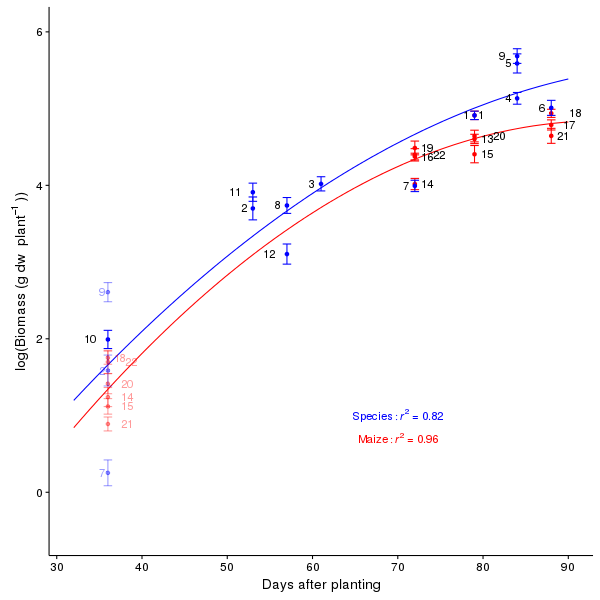

In [233]:
%%R -w 600 -h 600
# The errorbars overlapped, so use position_dodge to move them horizontally
require("cowplot")
aline = function(x) {coef(fit1_A)[3]*x ^ 2 + coef(fit1_A)[2]*x + coef(fit1_A)[1]}
mline = function(x) {coef(fit1_M)[3]*x ^ 2 + coef(fit1_M)[2]*x + coef(fit1_M)[1]}

pd = position_dodge(width = 4) # move them .05 to the left and right
## Show entire equation
# lm_eqn <- function(m){
#     eq <- substitute(italic(y) == a + b %.% italic(x) + 
#                      c %.% italic(x)^2*","~italic(r)^2~"="~r2, 
#          list(a = format(coef(m)[1], digits = 2), 
#               b = format(coef(m)[2], digits = 2),
#               c = format(coef(m)[3], digits = 2),
#              r2 = format(summary(m)$r.squared, digits = 3)))
#     as.character(as.expression(eq));                 
# }
# Show just R2
lm_eqn <- function(m){
    eq <- substitute(italic(r)^2~"="~r2,
         list(r2 = format(summary(m)$r.squared, digits = 2)))
    as.character(as.expression(eq));                 
}

eq.m = lm_eqn(fit1_M)
eq.a = lm_eqn(fit1_A)

p = ggplot(ARhiz) 
p = p + xlim(32, 92)
p = p + ylim(-.5, 6)

#p = p + theme_bw()
     
  

p = p + ylab(expression("log(Biomass (g dw " ~ plant^{-1}~"))"))
                         
p = p + xlab("Days after planting")

# add text for line equations
dftext <- data.frame(x = 70, y = 1, eq = as.character(eq.a))
p = p + geom_text(aes(x = x, y = y, label = paste("Species: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "blue", size = 4)

dftext <- data.frame(x = 70, y = .7, eq = as.character(eq.m))
p = p + geom_text(aes(x = x, y = y, label = paste("Maize: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "red", size = 4)


#p = p + geom_text(x = 60, y = 2, label = lm_eqn(fit1_M), parse = TRUE)
# line for annuals
p = p + stat_function(fun = aline, color = "blue")

# # line for maize 
p = p + stat_function(fun = mline, color = "red")


# # points for maize including sample A
p = p + geom_errorbar(data = SA_Maize, aes(x = DAP, ymin=logBiomass-logBiomass.se, 
                     ymax=logBiomass + logBiomass.se), width = 1, colour = "red", alpha = .4)
p = p + geom_point(data = SA_Maize,aes(x = DAP, y = logBiomass), colour = "red", alpha = .4)
p = p + geom_text(data = SA_Maize, aes(x = DAP, y = logBiomass, label = Labels, 
                                       hjust = c(-1.4, -1.1, -1.1, -.5, -1.1, -1.1)), 
                  colour = "red",  alpha = .4)
p = p + xlim(32, 90)



# # points for annuals including sample A
p = p + geom_errorbar(data = SA_Annuals, aes(x = DAP, ymin=logBiomass-logBiomass.se, 
                     ymax=logBiomass + logBiomass.se), width = 1, colour = "blue", alpha = .4)
p = p + geom_point(data = SA_Annuals,aes(x = DAP, y = logBiomass), colour = "blue", alpha = .4)
p = p + geom_text(data = SA_Annuals, aes(x = DAP, y = logBiomass, label = Labels), 
                  colour = "blue", hjust = 1.5, alpha = .4)



#Rhizosphere sampling points for maize
p = p + geom_errorbar(data = MRhiz, aes(x = DAP, ymin=logBiomass-logBiomass.se, 
                     ymax=logBiomass + logBiomass.se), position = pd, color = "red", width = 1)
p = p + geom_point(data = MRhiz,aes(x = DAP, y = logBiomass), position = pd, color = "red")     
p = p + geom_text(data = MRhiz, aes(x = DAP, y = logBiomass, label = Labels, 
                                    hjust = c(-.5,-.5, -.5, -.5, -.5, -1, -1.5, -.5, -1.5, -.5, -1.5)), position = pd, size = 4)


#Rhizosphere sampling points for annuals
p = p + geom_errorbar(data = ARhiz, aes(x = DAP, ymin=logBiomass-logBiomass.se, 
                     ymax=logBiomass + logBiomass.se), color = "blue", width = 1)
p = p + geom_point(data = ARhiz,aes(x = DAP, y = logBiomass), color = "blue")     
p = p + geom_text(data = ARhiz, aes(x = DAP, y = logBiomass, label = Labels,
                                    hjust = c(2,2,2,2,2,2,2,2,3,2,2,2)))  #position = position_dodge(width = 2), )

#p = p + scale_color_manual(values = color_annuals)
# p = p + ggtitle("Model of plant Biomass accumulation \n blue line annuals; red line maize")



p

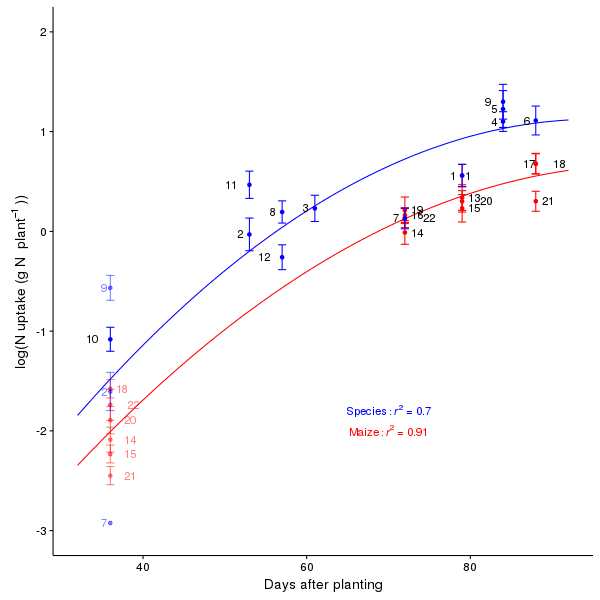

In [232]:
%%R -w 600 -h 600
# Graph N uptake and residuals
require("cowplot")
aline = function(x) {coef(fit2_A)[3]*x ^ 2 + coef(fit2_A)[2]*x + coef(fit2_A)[1]}
mline = function(x) {coef(fit2_M)[3]*x ^ 2 + coef(fit2_M)[2]*x + coef(fit2_M)[1]}


# lm_eqn <- function(m){
#     eq <- substitute(italic(y) == a + b %.% italic(x) + 
#                      c %.% italic(x)^2*","~italic(r)^2~"="~r2, 
#          list(a = format(coef(m)[1], digits = 2), 
#               b = format(coef(m)[2], digits = 2),
#               c = format(coef(m)[3], digits = 2),
#              r2 = format(summary(m)$r.squared, digits = 3)))
#     as.character(as.expression(eq));                 
# }
# Show just R2
lm_eqn <- function(m){
    eq <- substitute(italic(r)^2~"="~r2,
         list(r2 = format(summary(m)$r.squared, digits = 2)))
    as.character(as.expression(eq));                 
}

eq.m = lm_eqn(fit2_M)
eq.a = lm_eqn(fit2_A)

p1 = ggplot(ARhiz) 
p1 = p1 + xlim(32, 92)
p1 = p1 + ylim(-3, 2)


     
  

p1 = p1 + ylab(expression("log(N uptake (g N " ~ plant^{-1}~"))"))
p1 = p1 + xlab("Days after planting")

# add text for line equations
dftext <- data.frame(x = 70, y = -1.8, eq = as.character(eq.a))
p1 = p1 + geom_text(aes(x = x, y = y, label = paste("Species: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "blue", size = 4)

dftext <- data.frame(x = 70, y = -2, eq = as.character(eq.m))
p1 = p1 + geom_text(aes(x = x, y = y, label = paste("Maize: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "red", size = 4)
# line for annuals
p1 = p1 + stat_function(fun = aline, color = "blue")

# # line for maize 
p1 = p1 + stat_function(fun = mline, color = "red")


# # points for maize including sample A
p1 = p1 + geom_errorbar(data = SA_Maize, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), width = 1, colour = "red", alpha = .5)
p1 = p1 + geom_point(data = SA_Maize,aes(x = DAP, y = logNup), colour = "red", alpha = .5)
p1 = p1 + geom_text(data = SA_Maize, aes(x = DAP, y = logNup, label = Labels, 
                                        hjust = c(-1.4, -1.1, -1.1, -.5, -1.1, -1.1)), 
                  colour = "red", alpha = .5)


# # points for annuals including sample A
p1 = p1 + geom_errorbar(data = SA_Annuals, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), width = 1, colour = "blue", alpha = .5)
p1 = p1 + geom_point(data = SA_Annuals,aes(x = DAP, y = logNup), colour = "blue", alpha = .5)
p1 = p1 + geom_text(data = SA_Annuals, aes(x = DAP, y = logNup, label = Labels), 
                  colour = "blue", hjust = 1.5, alpha = .5)



#Rhizosphere sampling points for maize
p1 = p1 + geom_errorbar(data = MRhiz, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), color = "red", width = 1)
p1 = p1 + geom_point(data = MRhiz,aes(x = DAP, y = logNup), color = "red")     
p1 = p1 + geom_text(data = MRhiz, aes(x = DAP, y = logNup, label = Labels, 
                                    hjust = c(-.5,-.5, -.5, -.5, -.5, 1.1, -1.4, -.5, -1.5, -.5, -1.5)), position = pd, size = 4)


#Rhizosphere sampling points for annuals
p1 = p1 + geom_errorbar(data = ARhiz, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), color = "blue", width = 1)
p1 = p1 + geom_point(data = ARhiz,aes(x = DAP, y = logNup), color = "blue")     
p1 = p1 + geom_text(data = ARhiz, aes(x = DAP, y = logNup, label = Labels,
                                    hjust = c(2,2,2,2,2,2,2,2,3,2,2,2)))  #position = position_dodge(width = 2), )



p1

In [162]:
%%R
aline

function(x) {coef(fit3_A)[3]*x ^ 2 + coef(fit3_A)[2]*x + coef(fit3_A)[1]}


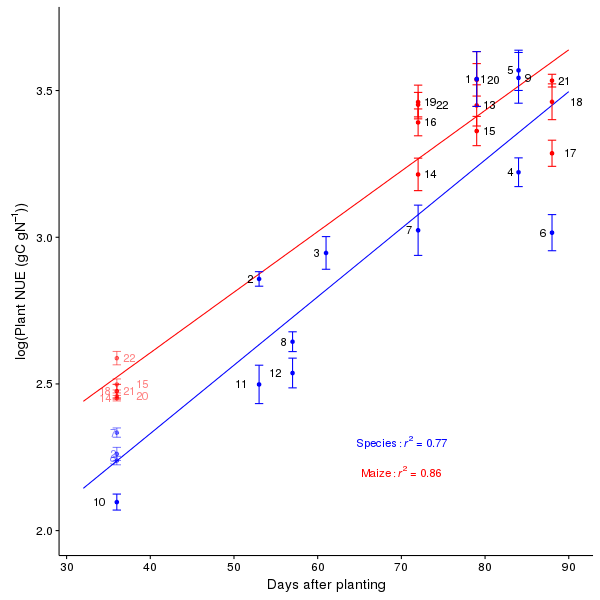

In [236]:
%%R -w 600 -h 600
# Graph N uptake and residuals
require("cowplot")
aline = function(x) {coef(fit3_A)[2]*x + coef(fit3_A)[1]}
mline = function(x) {coef(fit3_M)[2]*x + coef(fit3_M)[1]}


# lm_eqn <- function(m){
#     eq <- substitute(italic(y) == a + b %.% italic(x)*","~italic(r)^2~"="~r2,
#          list(a = format(coef(m)[1], digits = 2), 
#               b = format(coef(m)[2], digits = 2),
#              r2 = format(summary(m)$r.squared, digits = 3)))
#     as.character(as.expression(eq));                 
# }
lm_eqn <- function(m){
    eq <- substitute(italic(r)^2~"="~r2,
         list(r2 = format(summary(m)$r.squared, digits = 2)))
    as.character(as.expression(eq));                 
}

eq.m = lm_eqn(fit3_M)
eq.a = lm_eqn(fit3_A)

p2 = ggplot(ARhiz) 
p2 = p2 + xlim(32, 90)
p2 = p2 + ylim(2, 3.7)


     
  

p2 = p2 + ylab(expression("log(Plant NUE (g"*C ~gN^{-1}*"))"))
p2 = p2 + xlab("Days after planting")

# add text for line equations
dftext <- data.frame(x = 70, y = 2.3, eq = as.character(eq.a))
p2 = p2 + geom_text(aes(x = x, y = y, label = paste("Species: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "blue", size = 4)

dftext <- data.frame(x = 70, y = 2.2, eq = as.character(eq.m))
p2 = p2 + geom_text(aes(x = x, y = y, label = paste("Maize: ",eq, sep = "")), 
                  data = dftext, parse = TRUE, color = "red", size = 4)
# line for annuals
p2 = p2 + stat_function(fun = aline, color = "blue")

# # line for maize 
p2 = p2 + stat_function(fun = mline, color = "red")


# # points for maize including sample A
p2 = p2 + geom_errorbar(data = SA_Maize, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), width = 1, colour = "red", alpha = .5)
p2 = p2 + geom_point(data = SA_Maize,aes(x = DAP, y = logCN), colour = "red", alpha = .5)
p2 = p2 + geom_text(data = SA_Maize, aes(x = DAP, y = logCN, label = Labels,
                                        hjust = c(-.5, 1.5, -1.6, 1.5,-1.6,-.5)), 
                  colour = "red",  alpha = .5)

            

# # points for annuals including sample A
p2 = p2 + geom_errorbar(data = SA_Annuals, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), width = 1, colour = "blue", alpha = .5)
p2 = p2 + geom_point(data = SA_Annuals,aes(x = DAP, y = logCN), colour = "blue", alpha = .5)
p2 = p2 + geom_text(data = SA_Annuals, aes(x = DAP, y = logCN, label = Labels), 
                  colour = "blue", hjust = 1.1, alpha = .5)
p2 = p2 + xlim(32, 90)


#Rhizosphere sampling points for maize
p2 = p2 + geom_errorbar(data = MRhiz, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), color = "red", width = 1)
p2 = p2 + geom_point(data = MRhiz,aes(x = DAP, y = logCN), color = "red")     
p2 = p2 + geom_text(data = MRhiz, aes(x = DAP, y = logCN, label = Labels, 
                                    hjust = c(-.5,-.5, -.5, -.5, -.5, -1, -1.5, -.5, -.9, -.5, -1.5)), position = pd, size = 4)


#Rhizosphere sampling points for annuals
p2 = p2 + geom_errorbar(data = ARhiz, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), color = "blue", width = 1)
p2 = p2 + geom_point(data = ARhiz,aes(x = DAP, y = logCN), color = "blue")     
p2 = p2 + geom_text(data = ARhiz, aes(x = DAP, y = logCN, label = Labels,
                                    hjust = c(2,2,2,2,2,2,2,2,-1.1,2,2,2)))  #position = position_dodge(width = 2), )

c(22, 14, 15, 18,20,21)
c(-.5, 1.5, -1.6, 1.5,-1.6,-.5)
p2

In [237]:
%%R -w 750 -h 750
ThreePlots = plot_grid(p, p1, p2, labels = c("A", "B", "C"), nrow = 2, align = "v")

In [238]:
%%R
save_plot("ThreeGrowthCurves.pdf", ThreePlots,
          ncol = 2, # we're saving a grid plot of 2 columns
          nrow = 2, # and 2 rows
          # each individual subplot should have an aspect ratio of 1.3
          base_aspect_ratio = 1.3
          )

In [134]:
%%R -w 600 -h 600
# The errorbars overlapped, so use position_dodge to move them horizontally
pd = position_dodge(1) # move them .05 to the left and right

# lm_eqn <- function(m){
#     eq <- substitute(italic(y) == a + b %.% italic(x) + 
#                      c %.% italic(x)^2*","~~italic(r)^2~"="~r2, 
#          list(a = format(coef(m)[1], digits = 2), 
#               b = format(coef(m)[2], digits = 2),
#               c = format(coef(m)[3], digits = 2),
#              r2 = format(summary(m)$r.squared, digits = 3)))
#     as.character(as.expression(eq));                 
# }

p1 = ggplot()

p1 = p1 + theme_bw()
     
# line for annuals    
p1 = p1 + stat_smooth(data = Biomass_A,method = "lm", 
                aes(x = DAP, y = log(tN_p)),
                formula = y ~ poly(x, 2),size = 1, na.rm = TRUE)     
p1 = p1 + ylab("log(N uptake)")
p1 = p1 + xlab("Days after planting")

# line for maize 

p1 = p1 + stat_smooth(data = Biomass_M,method = "lm", 
                aes(x = DAP, y = log(tN_p)),
                formula = y ~ poly(x, 2),size = 1, colour = "red", na.rm = TRUE)     


# # points for annuals including sample A
p1 = p1 + geom_errorbar(data = AnnualsSA, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), width = 1, colour = "grey")
p1 = p1 + geom_point(data = AnnualsSA,aes(x = DAP, y = logNup), colour = "grey")
p1 = p1 + geom_text(data = AnnualsSA, aes(x = DAP, y = logNup, label = Plant), colour = "grey", hjust = 1.1, size = 4)
p1 = p1 + xlim(32, 90)

# # points for annuals including sample A
p1 = p1 + geom_errorbar(data = MaizeSA, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), width = 1, colour = "orange")
p1 = p1 + geom_point(data = MaizeSA,aes(x = DAP, y = logNup), colour = "orange")
p1 = p1 + geom_text(data = MaizeSA, aes(x = DAP, y = logNup, label = Plant), colour = "orange", hjust = 1.1, size = 4)
p1 = p1 + xlim(32, 90)

#Rhizosphere sampling points for maize
p1 = p1 + geom_errorbar(data = MRhiz, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), colour = "red", width = 1)
p1 = p1 + geom_point(data = MRhiz,aes(x = DAP, y = logNup), colour = "red")     
p1 = p1 + geom_text(data = MRhiz, aes(x = DAP, y = logNup, label = Plant), , colour = "red", hjust = 1.1, size = 4)

#Rhizosphere sampling points for annuals
p1 = p1 + geom_errorbar(data = ARhiz, aes(x = DAP, ymin=logNup-logNup.se, 
                     ymax=logNup + logNup.se), width = 1)
p1 = p1 + geom_point(data = ARhiz,aes(x = DAP, y = logNup))     
p1 = p1 + geom_text(data = ARhiz, aes(x = DAP, y = logNup, label = Plant), hjust = 1.1, size = 4)
p1 = p1 + ggtitle("Model of plant N uptake \n blue line annuals; red line maize")



In [129]:
%%R -w 600 -h 600
# The errorbars overlapped, so use position_dodge to move them horizontally
pd = position_dodge(1) # move them .05 to the left and right

# lm_eqn <- function(m){
#     eq <- substitute(italic(y) == a + b %.% italic(x) + 
#                      c %.% italic(x)^2*","~~italic(r)^2~"="~r2, 
#          list(a = format(coef(m)[1], digits = 2), 
#               b = format(coef(m)[2], digits = 2),
#               c = format(coef(m)[3], digits = 2),
#              r2 = format(summary(m)$r.squared, digits = 3)))
#     as.character(as.expression(eq));                 
# }

p2 = ggplot()

p2 = p2 + theme_bw()
     
# line for annuals    
p2 = p2 + stat_smooth(data = Biomass_A, method = "lm", 
                aes(x = DAP, y = log(Plant_CN)),
                formula = y ~ x,size = 1, na.rm = TRUE)     
p2 = p2 + ylab("log(N uptake)")
p2 = p2 + xlab("Days after planting")

# line for maize 

p2 = p2 + stat_smooth(data = Biomass_M,method = "lm", 
                aes(x = DAP, y = log(Plant_CN)),
                formula = y ~ x,size = 1, colour = "red", na.rm = TRUE)     


# # points for annuals including sample A
p2 = p2 + geom_errorbar(data = AnnualsSA, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), width = 1, colour = "grey")
p2 = p2 + geom_point(data = AnnualsSA,aes(x = DAP, y = logCN), colour = "grey")
p2 = p2 + geom_text(data = AnnualsSA, aes(x = DAP, y = logCN, label = Plant), colour = "grey", hjust = 1.1, size = 4)
p2 = p2 + xlim(32, 90)

# # points for annuals including sample A
p2 = p2 + geom_errorbar(data = MaizeSA, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), width = 1, colour = "orange")
p2 = p2 + geom_point(data = MaizeSA,aes(x = DAP, y = logCN), colour = "orange")
p2 = p2 + geom_text(data = MaizeSA, aes(x = DAP, y = logCN, label = Plant), colour = "orange", hjust = 1.1, size = 4)
p2 = p2 + xlim(32, 90)

#Rhizosphere sampling points for maize
p2 = p2 + geom_errorbar(data = MRhiz, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), colour = "red", width = 1)
p2 = p2 + geom_point(data = MRhiz,aes(x = DAP, y = logCN), colour = "red")     
p2 = p2 + geom_text(data = MRhiz, aes(x = DAP, y = logCN, label = Plant), , colour = "red", hjust = 1.1, size = 4)

#Rhizosphere sampling points for annuals
p2 = p2 + geom_errorbar(data = ARhiz, aes(x = DAP, ymin=logCN-logCN.se, 
                     ymax=logCN + logCN.se), width = 1)
p2 = p2 + geom_point(data = ARhiz,aes(x = DAP, y = logCN))     
p2 = p2 + geom_text(data = ARhiz, aes(x = DAP, y = logCN, label = Plant), hjust = 1.1, size = 4)
p2 = p2 + ggtitle("Model of plant C:N with time \n blue line annuals; red line maize")



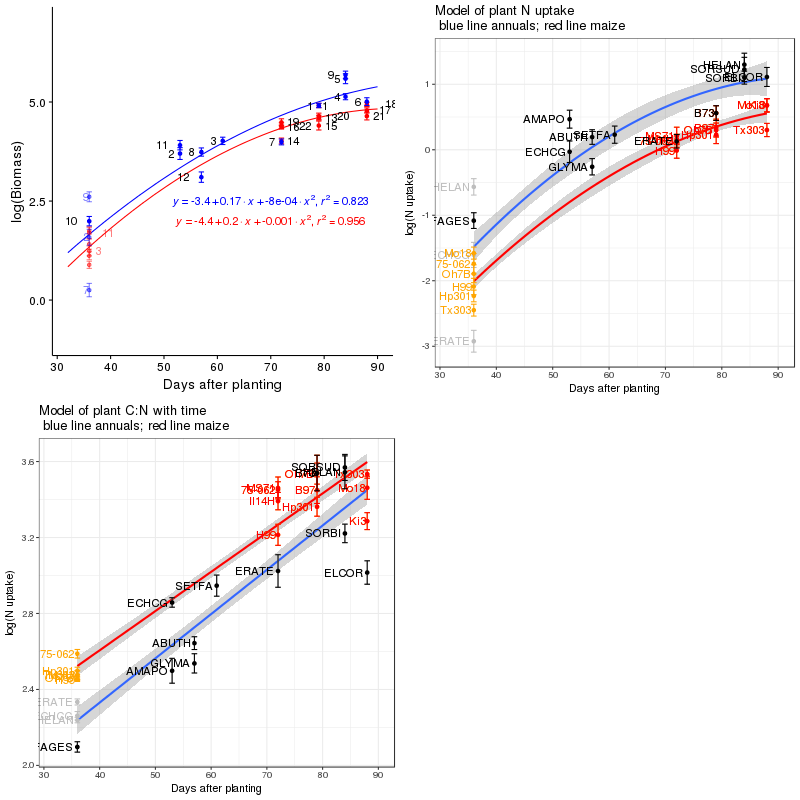

In [130]:
%%R -w 800 -h 800
grid.arrange(p, p1, p2, ncol = 2)

In [131]:
# Test for differences in growth residuals